Snippet to load and visualize the dataset


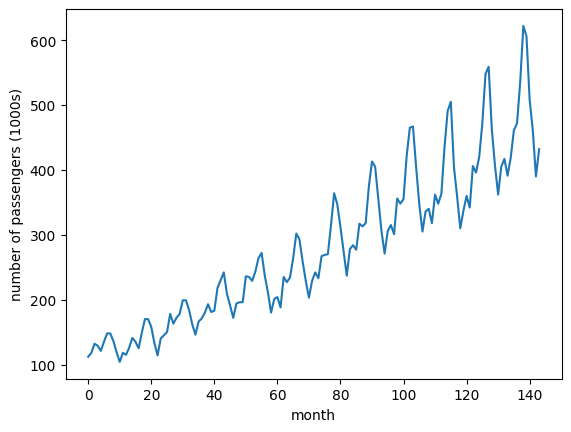

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import blocks
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

##use this only if you didn't download yet the csv file##
##!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

training_set = pd.read_csv('airline-passengers.csv')

training_set = training_set.iloc[:,1:2].values
#print(training_set[0])

plt.xlabel('month')
plt.ylabel('number of passengers (1000s)')
plt.plot(training_set)
plt.show()

In [2]:
sc = MinMaxScaler()
data = sc.fit_transform(training_set)

test_size=36
training_data=data[:len(data)-test_size]

print("train-set samples: ",training_data.size)

train-set samples:  108


In [3]:
batch=10
seq_length=8
embedding_dim=10
num_features=1

#create the generator
G=blocks.Generator(embedding_dim,seq_length,num_features)
G.addBlock()
 

#random predictions
for epoch in range(3):
    p=G(training_data,batch,epoch)
print(p.shape)

kernel_size:  1
torch.Size([10, 32])


torch.Size([1, 32])


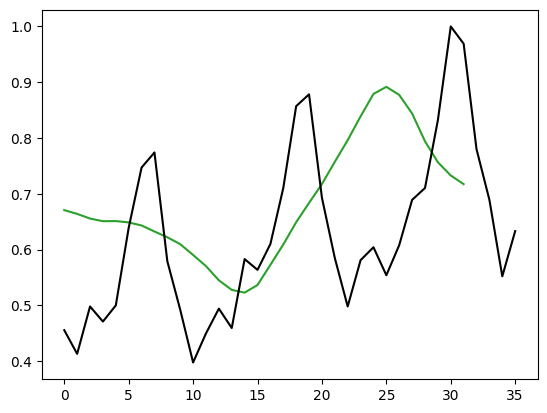

In [4]:
#plot the results and compare with the real data
color="green"
p=G(data,1,len(data)-test_size-seq_length)
print(p.shape)

plt.plot(p[0].detach().numpy(),color=f"tab:{color}")
plt.plot(data[-test_size:],color="black")

# *Train*

### Moment loss

In [5]:
def moment_loss(fake_data, real_data):
    fake_mean = fake_data.mean()
    real_mean = real_data.mean()
    fake_std = fake_data.std()
    real_std = real_data.std()
    return abs(fake_mean - real_mean) + abs(fake_std - real_std)

### Path model save

In [6]:
import os
path = "models"
# Check whether the specified path exists or not
isExist = os.path.exists(path)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(path)
   print("The new models directory is created!")